# COVID-19 in Virginia
### Time series analysis of daily new cases

The data for this analysis was retrieved from the Virginia Department of Health's (VDH) COVID-19 data page. Specifically, I am using the [Cases Summary Public Use Dataset](https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases-Summary/3ves-mpfr), which is available for download with daily updated data.

For this analysis, I will utilize the `pandas`, `numpy`, and `matplotlib` libraries.

In [101]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
# use pandas to load the data set downloaded from the VDH
covid = pd.read_csv(
    "VDH-COVID-19-PublicUseDataset-Cases-Summary.csv"
)

# examine the first 5 rows of the data set
covid.head(5)

,Report Date,Summary Indicator,Summary Indicator Value
0,11/07/2020,Total Cases,"190,873"
1,11/07/2020,New Cases,"2,103"
2,11/07/2020,Confirmed Cases,"175,187"
3,11/07/2020,Probable Cases,"15,686"
4,11/07/2020,Total Hospitalizations,"13,022"


In [103]:
# examine the last 5 rows of the data set
covid.tail(5)

,Report Date,Summary Indicator,Summary Indicator Value
4109,07/23/2021,Number_of_PCR_Testing_Encounters,"7,894,656"
4110,07/23/2021,Number_of_Outbreak_Associated_Cases,"77,721"
4111,07/23/2021,Current 7-Day Percent Positivity,3.7%
4112,07/23/2021,MIS-C Cases,77
4113,07/23/2021,MIS-C Deaths,0


We can see that our data set includes three fields:
- The report date, beginning on November 28, 2020 and ending on July 23, 2021
- A summary indicator...we are interested in the "New Cases" indicator
- A summary indicator value that gives the value for the specified indicator on the specified date

To conduct our analysis, we need to filter our data set to include only the rows for which the Summary Indicator field contains "New Cases."

In [104]:
# create a new data frame for the new case data
new_cases = covid[covid["Summary Indicator"] == "New Cases"].copy()

# examine the first 5 rows of the new cases data set
new_cases.head(5)

,Report Date,Summary Indicator,Summary Indicator Value
1,11/07/2020,New Cases,"2,103"
17,11/08/2020,New Cases,"1,302"
33,11/09/2020,New Cases,"1,302"
49,11/10/2020,New Cases,"1,435"
65,11/11/2020,New Cases,"1,594"


Before we being any time series analysis, we need to ensure that our date column is the proper data type.

In [105]:
# examine the data types
new_cases.dtypes

Report Date                object
Summary Indicator          object
Summary Indicator Value    object
dtype: object

Since the Report Date field is an object, in this case a string, we need to convert it to a proper `datetime` type. Additionally, the Summary Indicator Value field is a string; we need to remove the ',' character and convert it to a numeric data type.

We also want to set the index of the data frame to the 'Report Date' field.

In [106]:
# convert 'Report Date' to datetime type
new_cases["Report Date"] = pd.to_datetime(new_cases["Report Date"])

# remove the ',' character and convert 'Summary Indicator Value' to numeric type
new_cases = new_cases.replace(',', '', regex = True)
new_cases["Summary Indicator Value"] = pd.to_numeric(new_cases["Summary Indicator Value"])

# ensure the dates are in the proper order
new_cases = new_cases.sort_values(by = ["Report Date"])

# set the index to the 'Report Date' field
new_cases = new_cases.set_index("Report Date")

# examine the data types
new_cases.dtypes

Summary Indicator          object
Summary Indicator Value     int64
dtype: object

Now let's visualize the daily new COVID-19 case data for Virginia using `matplotlib`. We start by defining a chart formatting function so we are not repeating a lot of formatting syntax throughout the analysis.

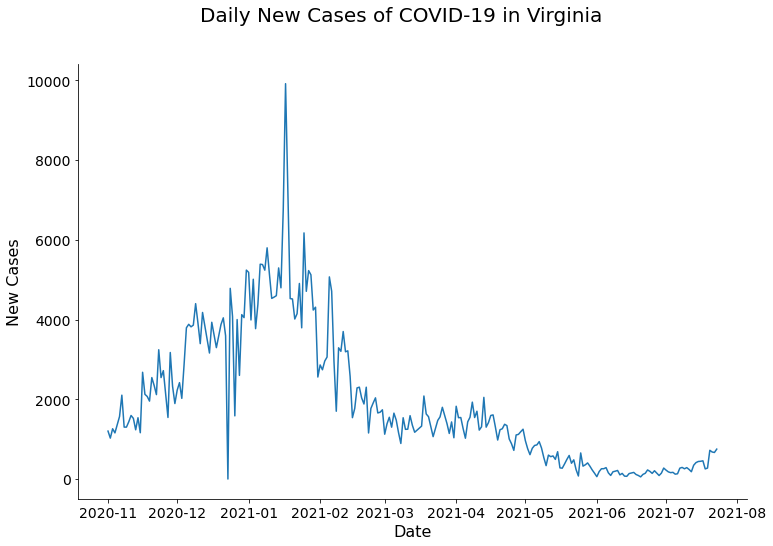

In [107]:
# chart formatting funcion
def ChartFormatter(title, legend = True):
    # set the x- and y-axis tick parameters
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    # Use automatic StrMethodFormatter
    #ax.yaxis.set_major_formatter("{x:,.0f}")

    # hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if (legend):
        # add a legend
        ax.legend()
    
    ##### Figure object properties #####
    # give the chart a title
    fig.suptitle(title, fontsize = 20)

    # set the size of the chart
    fig.set_size_inches(12, 8)

# create variables for the Figure and Axes objects
fig, ax = plt.subplots()

##### Axes object properties #####
# create two line plots
ax.plot(new_cases["Summary Indicator Value"])

# set the x- and y-axis labels
ax.xaxis.set_label_text("Date", fontsize = 16)
ax.yaxis.set_label_text("New Cases", fontsize = 16)

ChartFormatter("Daily New Cases of COVID-19 in Virginia", legend = False)

## Analyzing the Trend

The interesting piece here is determining the optimal window for the moving average. Most media outlets report a 7-day moving average, but is that the most accurate? We will start there, and look at other values for our window size to determine whether we can find something better.

In [108]:
new_cases["MovingAverage"] = new_cases.iloc[:, 1].rolling(7).mean()
new_cases["SquaredError"] = (new_cases["Summary Indicator Value"] - new_cases["MovingAverage"]) ** 2

Now we can visualize the daily new case data along with our moving average.

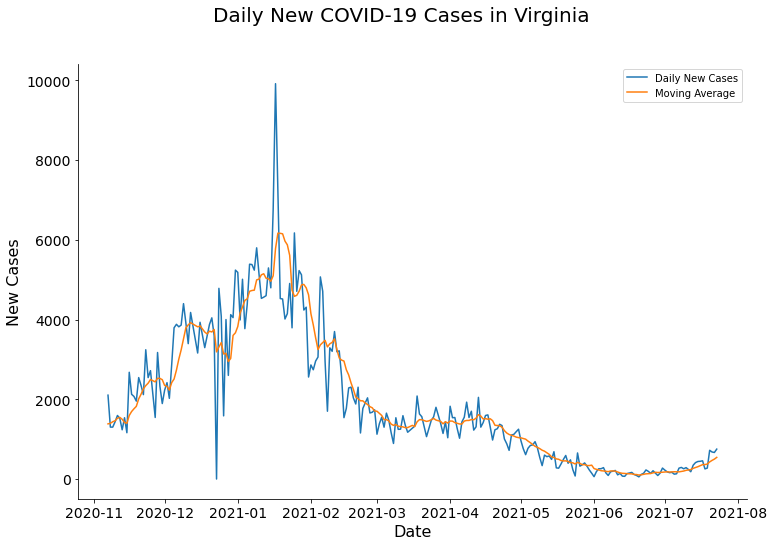

In [109]:
# remove "na" rows
new_cases7 = new_cases.dropna(how = "any", inplace = True)

# create variables for the Figure and Axes objects
fig, ax = plt.subplots()

##### Axes object properties #####
# create two line plots
ax.plot(new_cases["Summary Indicator Value"], label = "Daily New Cases")
ax.plot(new_cases["MovingAverage"], label = "Moving Average")

# set the x- and y-axis labels
ax.xaxis.set_label_text("Date", fontsize = 16)
ax.yaxis.set_label_text("New Cases", fontsize = 16)

ChartFormatter("Daily New COVID-19 Cases in Virginia")

In [110]:
print(new_cases["SquaredError"].sum())

98782913.3877551


The chart above shows that the 7-day moving average does a very nice job of capturing the trend in the daily new cases data, so I suspect it will be tough to beat. Let's take a look at a 10-day moving average.

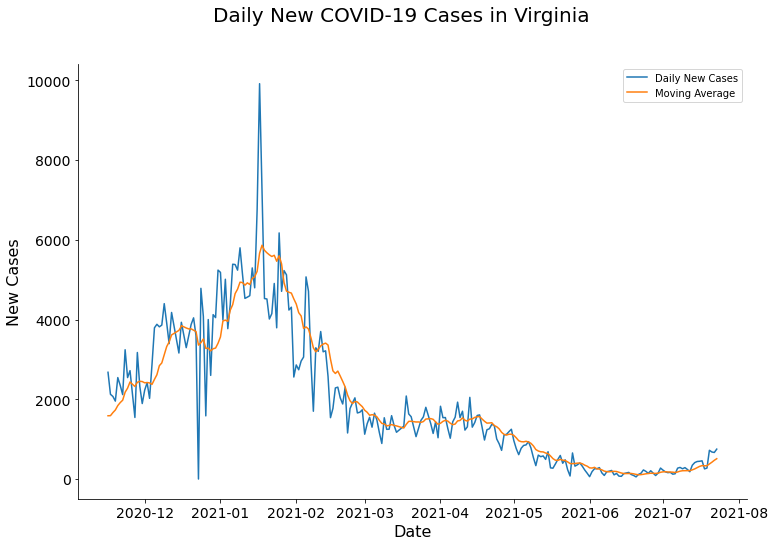

In [111]:
new_cases["MovingAverage"] = new_cases.iloc[:, 1].rolling(10).mean()
new_cases["SquaredError"] = (new_cases["Summary Indicator Value"] - new_cases["MovingAverage"]) ** 2

# remove "na" rows
new_cases10 = new_cases.dropna(how = "any", inplace = True)

# create variables for the Figure and Axes objects
fig, ax = plt.subplots()

##### Axes object properties #####
# create two line plots
ax.plot(new_cases["Summary Indicator Value"], label = "Daily New Cases")
ax.plot(new_cases["MovingAverage"], label = "Moving Average")

# set the x- and y-axis labels
ax.xaxis.set_label_text("Date", fontsize = 16)
ax.yaxis.set_label_text("New Cases", fontsize = 16)

ChartFormatter("Daily New COVID-19 Cases in Virginia")

In [112]:
print(new_cases["SquaredError"].sum())

103703149.95


The 10-day moving average doesn't do as good of a job at capturing the trend and it's sum of squared errors is higher. Let's try 14 days for the window.

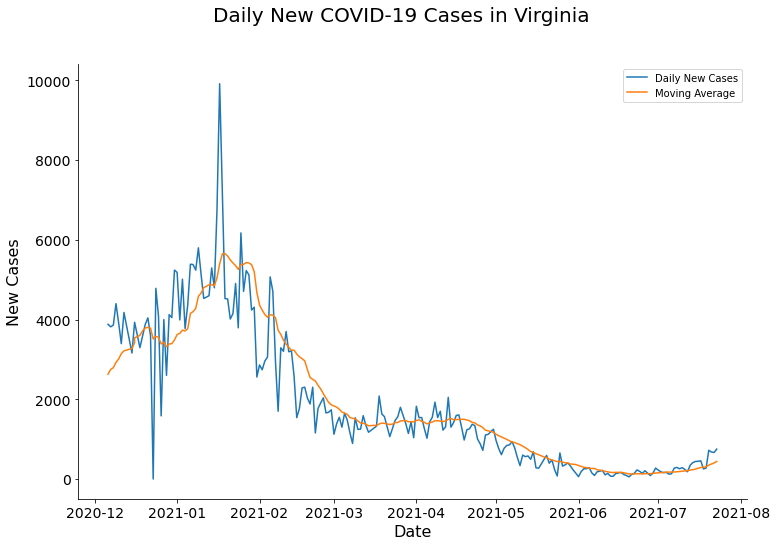

In [114]:
new_cases["MovingAverage"] = new_cases.iloc[:, 1].rolling(14).mean()
new_cases["SquaredError"] = (new_cases["Summary Indicator Value"] - new_cases["MovingAverage"]) ** 2

# remove "na" rows
new_cases14 = new_cases.dropna(how = "any", inplace = True)

# create variables for the Figure and Axes objects
fig, ax = plt.subplots()

##### Axes object properties #####
# create two line plots
ax.plot(new_cases["Summary Indicator Value"], label = "Daily New Cases")
ax.plot(new_cases["MovingAverage"], label = "Moving Average")

# set the x- and y-axis labels
ax.xaxis.set_label_text("Date", fontsize = 16)
ax.yaxis.set_label_text("New Cases", fontsize = 16)

ChartFormatter("Daily New COVID-19 Cases in Virginia")

In [115]:
print(new_cases["SquaredError"].sum())

113369660.24489795


From the 10- and 14-day moving averages, it appears that going past 7 days produces greater error. Let's go in the opposite direction and try a 5-day moving average.

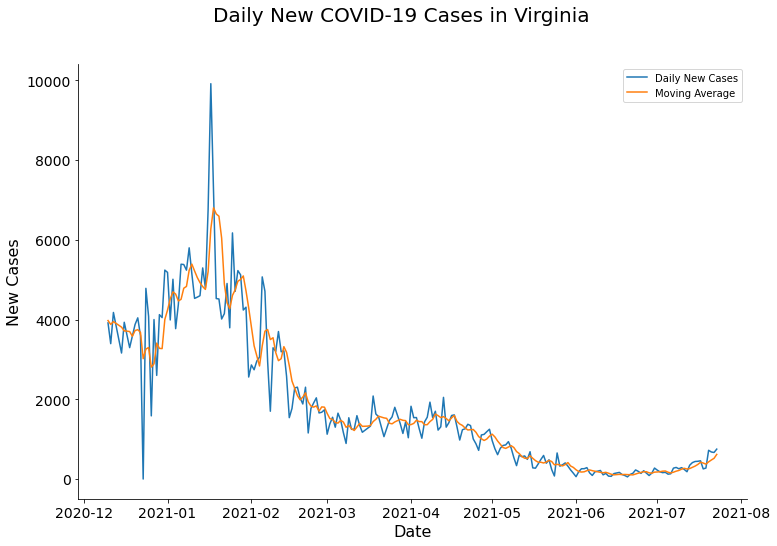

In [116]:
new_cases["MovingAverage"] = new_cases.iloc[:, 1].rolling(5).mean()
new_cases["SquaredError"] = (new_cases["Summary Indicator Value"] - new_cases["MovingAverage"]) ** 2

# remove "na" rows
new_cases5 = new_cases.dropna(how = "any", inplace = True)

# create variables for the Figure and Axes objects
fig, ax = plt.subplots()

##### Axes object properties #####
# create two line plots
ax.plot(new_cases["Summary Indicator Value"], label = "Daily New Cases")
ax.plot(new_cases["MovingAverage"], label = "Moving Average")

# set the x- and y-axis labels
ax.xaxis.set_label_text("Date", fontsize = 16)
ax.yaxis.set_label_text("New Cases", fontsize = 16)

ChartFormatter("Daily New COVID-19 Cases in Virginia")

In [117]:
print(new_cases["SquaredError"].sum())

78442693.79999998


The 5-day moving average is our best try yet; it captures the trend nicely and has a lower sum of squared errors than the 7-day moving average. Now that we have a good window size, let's use it and get our first residuals.

In [120]:
# calculate the first residual and the first residual percentage
new_cases["R1"] = new_cases["Summary Indicator Value"] - new_cases["MovingAverage"]
new_cases["R1Error"] = abs((new_cases["Summary Indicator Value"] - new_cases["R1"]) / new_cases["Summary Indicator Value"])

new_cases

,Summary Indicator,Summary Indicator Value,MovingAverage,SquaredError,R1,R1Error
Report Date,,,,,,
2020-12-10,New Cases,3915,3974.0,3481.00,-59.0,1.015070
2020-12-11,New Cases,3395,3877.0,232324.00,-482.0,1.141973
2020-12-12,New Cases,4177,3949.0,51984.00,228.0,0.945415
2020-12-15,New Cases,3160,3809.0,421201.00,-649.0,1.205380
2020-12-16,New Cases,3931,3715.6,46397.16,215.4,0.945205
...,...,...,...,...,...,...
2021-07-19,New Cases,275,374.2,9840.64,-99.2,1.360727
2021-07-20,New Cases,721,430.4,84448.36,290.6,0.596949
2021-07-21,New Cases,678,477.0,40401.00,201.0,0.703540


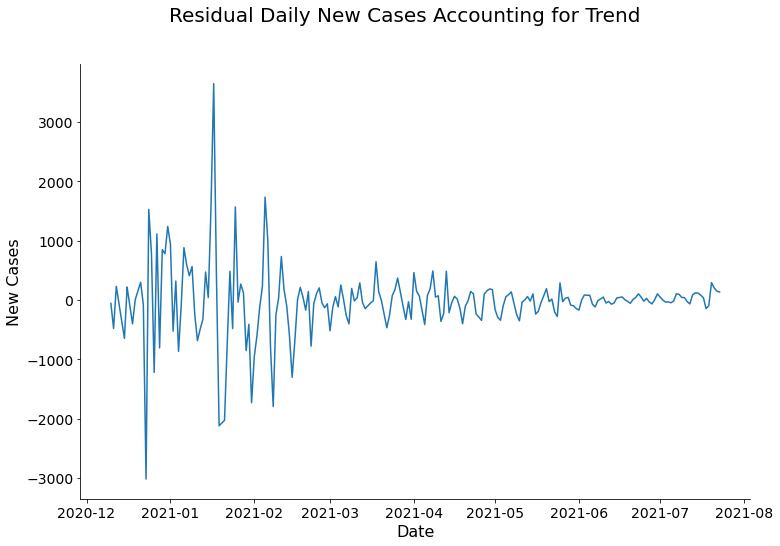

In [121]:
# create variables for the Figure and Axes objects
fig, ax = plt.subplots()

##### Axes object properties #####
# create two line plots
ax.plot(new_cases["R1"])

# set the x- and y-axis labels
ax.xaxis.set_label_text("Date", fontsize = 16)
ax.yaxis.set_label_text("New Cases", fontsize = 16)

ChartFormatter("Residual Daily New Cases Accounting for Trend", legend = False)

The first residual values have a large variance up to March 2021, at which point the variance shows a pronounced decrease.